<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [73]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [74]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-03-30 22:14:51--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-03-30 22:14:51 (13.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [75]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [76]:
df.shape

(346, 10)

### Convert to date time object 

In [77]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [78]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seaborn-0.10.0             |             py_0         161 KB  anaconda
    certifi-2019.11.28         |           py36_1         157 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following packages will be UPDATED:

    ca-certificates: 2020.1.1-0         --> 2020.1.1-0        anaconda
    certifi:         2019.11.28-py36_0  --> 2019.11.28-py36_1 anaconda
    openssl:         1.1.1e-h7b6447c_0  --> 1.1.1-h7b6447c_0  anaconda
    seaborn:         0.9.0-pyh91

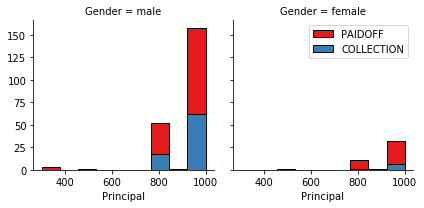

In [79]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

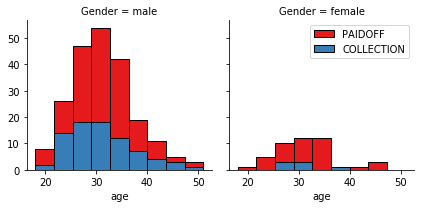

In [80]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

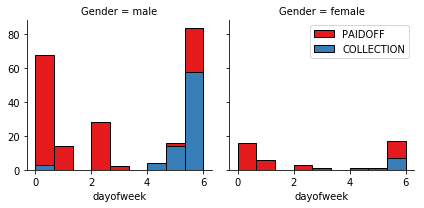

In [81]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [82]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [83]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [84]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [85]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [86]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [87]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [88]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [89]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [90]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

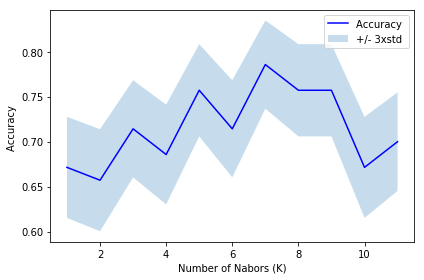

    Accuracy
k           
1   0.671429
2   0.657143
3   0.714286
4   0.685714
5   0.757143
6   0.714286
7   0.785714
8   0.757143
9   0.757143
10  0.671429
The best cross validation accuracy was with 0.7857142857142857 with k= 7
Train set Accuracy:  0.7898550724637681
Test set Accuracy:  0.7


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#train test split 

X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split( X, y, test_size=0.2, random_state=4)


Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_KNN,y_train_KNN)
    yhat_KNN=neigh.predict(X_test_KNN)
    mean_acc[n-1] = metrics.accuracy_score(y_test_KNN, yhat_KNN)

    
    std_acc[n-1]=np.std(yhat_KNN==y_test_KNN)/np.sqrt(yhat_KNN.shape[0])



plt.plot(range(1,Ks),mean_acc,'b')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.25)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

k_accuracy = np.array(mean_acc)

k_tables = pd.DataFrame(data=k_accuracy, columns=["Accuracy"]).shift()[1:]
k_tables.index.name = 'k'

print(k_tables)
print( "The best cross validation accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
print("Train set Accuracy: ", metrics.accuracy_score(y_train_KNN, neigh.predict(X_train_KNN)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test_KNN, yhat_KNN))

In [92]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

print("Jaccard score for KNN model: ", jaccard_similarity_score(y_test_KNN,yhat_KNN))
print("Logloss score for KNN model: ", log_loss(y_test_KNN,neigh.predict_proba(X_test_KNN)))
print("F1 score for KNN model: ", f1_score(y_test_KNN,yhat_KNN,average='weighted'))

Jaccard score for KNN model:  0.7
Logloss score for KNN model:  0.4800808448910849
F1 score for KNN model:  0.696178937558248


# Decision Tree

In [45]:
!conda install pydotplus

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_1         157 KB
    ca-certificates-2020.1.1   |                0         132 KB
    pydotplus-2.0.2            |             py_1          23 KB
    ------------------------------------------------------------
                                           Total:         312 KB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-py_1                

The following packages will be UPDATED:

    ca-certificates: 2020.1.1-0        anaconda --> 2020.1.1-0       
    certifi:         2019.11.28-py36_1 anaconda --> 2019.11.28-py36_1

The following packages will be DOWNGRADED:

    openssl:         1.1.1-h7b6447c_0  anaconda --> 1.1.1e-h7b6447c

In [46]:
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    python-graphviz-0.13.2     |             py_0          18 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    python-graphviz: 0.13.2-py_0       conda-forge
    python_abi:      3.6-1_cp36m       conda-forge

The following packages will be UPDATED

DecisionTrees's Accuracy:  0.6538461538461539


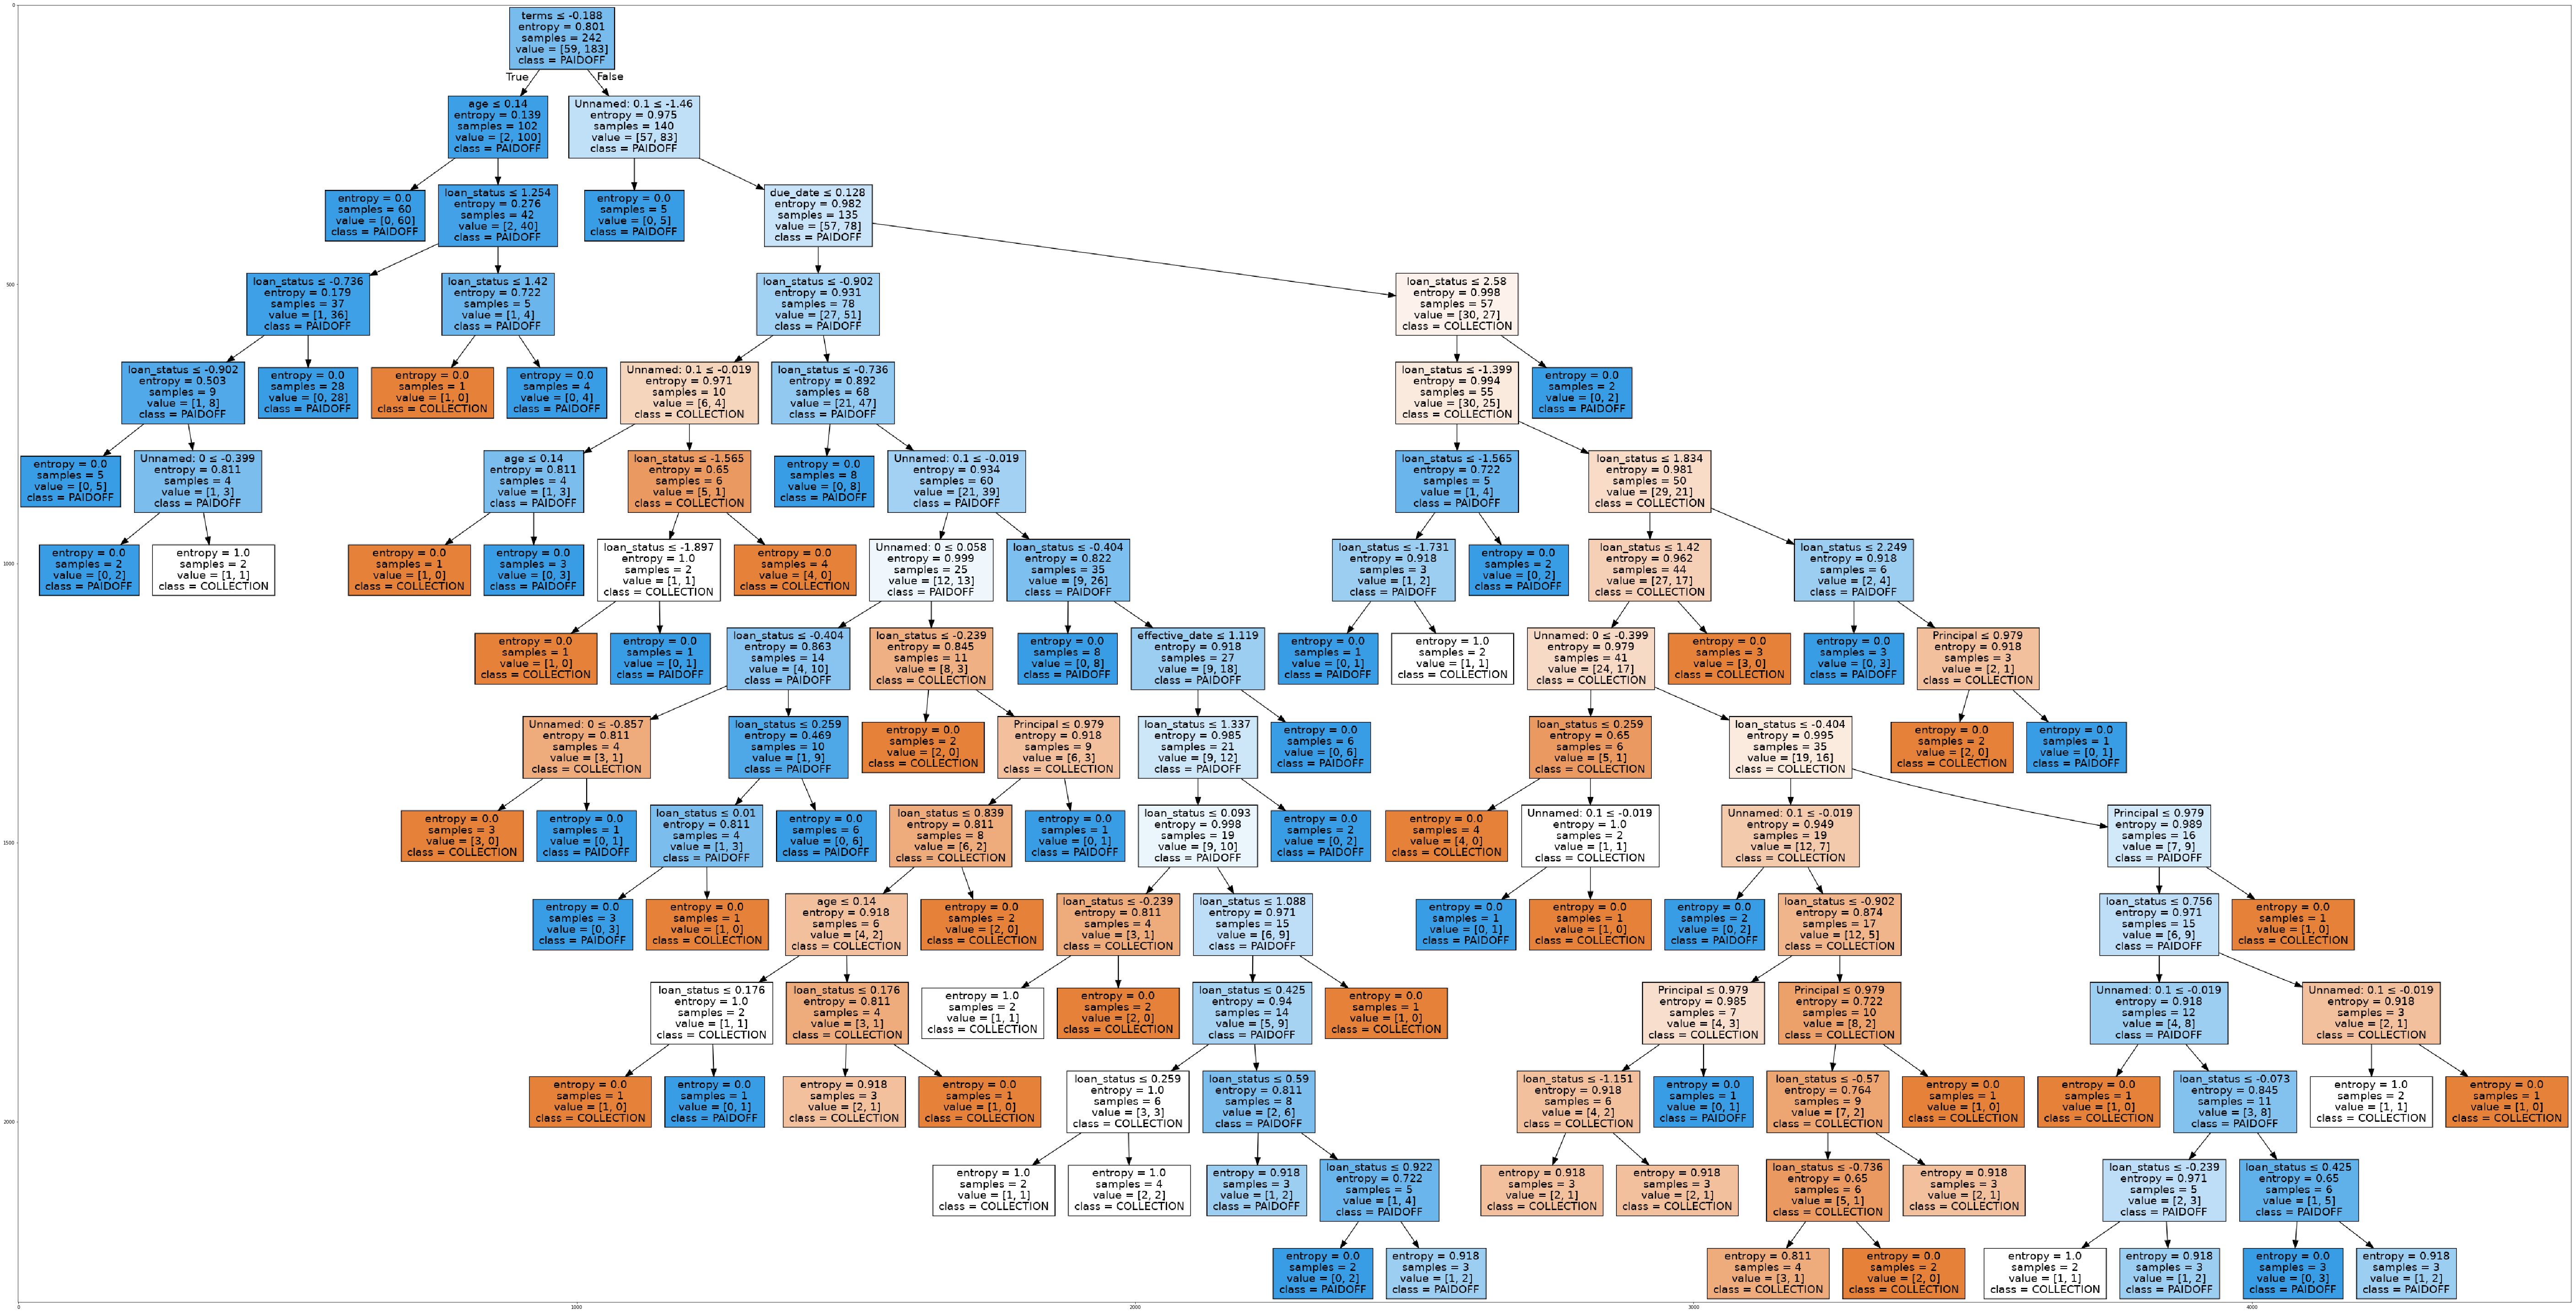

In [95]:
#!conda install pydotplus
#!conda install -c conda-forge python-graphviz -y

from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from graphviz import Digraph
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline 

X_train_TREE, X_test_TREE, y_train_TREE, y_test_TREE = train_test_split(X, y, test_size=0.3, random_state=3)

LoansTree = DecisionTreeClassifier(criterion="entropy")
LoansTree.fit(X_train_TREE,y_train_TREE)
predTree = LoansTree.predict(X_test_TREE)

LoansTree.fit(X_train_TREE,y_train_TREE)
yhat_TREE = LoansTree.predict(X_test_TREE)

#Visualize
dot_data = StringIO()
filename = "drugtree.png"
featureNames = df.columns[0:8]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(LoansTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train_TREE), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')


print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test_TREE, predTree))


In [96]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

print("Jaccard score for Decission TREE model: ", jaccard_similarity_score(y_test_TREE,yhat_TREE))
print("Logloss score for Decission TREE model: ", log_loss(y_test_TREE,neigh.predict_proba(X_test_TREE)))
print("F1 score for Decission TREE model: ", f1_score(y_test_TREE,yhat_TREE,average='weighted'))

Jaccard score for Decission TREE model:  0.6538461538461539
Logloss score for Decission TREE model:  0.4772868815786767
F1 score for Decission TREE model:  0.6611671087533157


# Support Vector Machine

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.81      0.87      0.84        55
           1       0.36      0.27      0.31        15

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


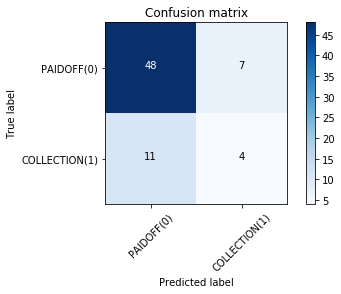

In [101]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools


#Change the catagorical labels PAIDOFF and COLLECTIONS to 0 and 1
y_binary = df['loan_status'].apply(lambda loan_status: 0 if loan_status == 'PAIDOFF' else 1)
y_binary.head()

X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split( X, y_binary, test_size=0.2, random_state=4) #here used y_binary to change 

clf = svm.SVC(kernel='rbf')
clf.fit(X_train_SVM, y_train_SVM) 





yhat_SVM = clf.predict(X_test_SVM) #here we basically change from PAIDOFF and COLLECTIONS to 0 and 1 from where we define in y_binary
#yhat [0:5]



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_SVM, yhat_SVM, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test_SVM, yhat_SVM))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(0)','COLLECTION(1)'],normalize= False,  title='Confusion matrix')

In [102]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

print("Jaccard score for Decission TREE model: ", jaccard_similarity_score(y_test_SVM,yhat_SVM))
print("Logloss score for Decission TREE model: ", log_loss(y_test_SVM,neigh.predict_proba(X_test_SVM)))
print("F1 score for Decission TREE model: ", f1_score(y_test_SVM,yhat_SVM,average='weighted'))

Jaccard score for Decission TREE model:  0.7428571428571429
Logloss score for Decission TREE model:  8.70463810970327
F1 score for Decission TREE model:  0.7275882012724117


# Logistic Regression

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

yhat = LR.predict(X_test)

yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.5 , 0.5 ],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.32, 0.68],
       [0.32, 0.68],
       [0.49, 0.51],
       [0.48, 0.52],
       [0.34, 0.66],
       [0.49, 0.51],
       [0.34, 0.66],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.34, 0.66],
       [0.44, 0.56],
       [0.26, 0.74],
       [0.52, 0.48],
       [0.3 , 0.7 ],
       [0.5 , 0.5 ],
       [0.32, 0.68],
       [0.44, 0.56],
       [0.49, 0.51],
       [0.51, 0.49],
       [0.47, 0.53],
       [0.41, 0.59],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.37, 0.63],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.47, 0.53],
       [0.46, 0.54],
       [0.46, 0.54],
       [0.48, 0.52],
       [0.39, 0.61],
       [0.46, 0.54],
       [0.5 , 0.5 ],
       [0.29, 0.71],
       [0.46, 0.54],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.32, 0.68],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.31, 0.69],
       [0.5 , 0.5 ],
       [0.47, 0.53],
       [0.5 ,

[[ 2 13]
 [ 9 46]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        55
           1       0.18      0.13      0.15        15

   micro avg       0.69      0.69      0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]


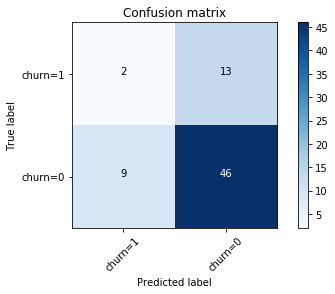

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools


y_binary = df['loan_status'].apply(lambda loan_status: 0 if loan_status == 'PAIDOFF' else 1)
y_binary.head()


X_train_LOR, X_test_LOR, y_train_LOR, y_test_LOR = train_test_split( X, y_binary, test_size=0.2, random_state=4)

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_LOR,y_train_LOR)
#LR

yhat_LOR = LR.predict(X_test_LOR)

yhat_prob_LOR = LR.predict_proba(X_test_LOR)
#yhat_prob


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test_LOR, yhat_LOR, labels=[1,0]))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_LOR, yhat_LOR, labels=[1,0])
np.set_printoptions(precision=2)

print (classification_report(y_test_LOR, yhat_LOR))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [108]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

print("Jaccard score for Logistic Regression model: ", jaccard_similarity_score(y_test_LOR,yhat_LOR))
print("Logloss score for Logistic Regression model: ", log_loss(y_test_LOR,neigh.predict_proba(X_test_LOR)))
print("F1 score for Logistic Regression model: ", f1_score(y_test_LOR,yhat_LOR,average='weighted'))

Jaccard score for Logistic Regression model:  0.6857142857142857
Logloss score for Logistic Regression model:  8.70463810970327
F1 score for Logistic Regression model:  0.6670522459996144


# Model Evaluation using Test set

In [132]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [133]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-03-30 22:41:29--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-03-30 22:41:29 (348 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [134]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [137]:
test_df = pd.read_csv('loan_test.csv')
# convert date time
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
# evaulate weekend field
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# convert male to 0 and female to 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# work out education level
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
# Testing feature
X_loan_test = test_feature
# normalize the test data
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test).transform(X_loan_test)
# and target result
y_loan_test = test_df['loan_status'].values
y_loan_test[0:5]
print (X_loan_test[0:5])
print (X_loan_test.shape)
print (y_loan_test[0:5])
print (y_loan_test.shape)

[[ 0.49  0.93  3.06  1.98 -1.3   2.4  -0.8  -0.86]
 [-3.56 -1.7   0.53 -0.51  0.77 -0.42 -0.8  -0.86]
 [ 0.49  0.93  1.88  1.98  0.77 -0.42  1.25 -0.86]
 [ 0.49  0.93 -0.98 -0.51  0.77 -0.42 -0.8   1.16]
 [-0.67 -0.79 -0.48 -0.51  0.77  2.4  -0.8  -0.86]]
(54, 8)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
(54,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:17: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [151]:
# Jaccard setup
from sklearn.metrics import jaccard_similarity_score
from sklearn import svm

# evaluate KNN
knn_yhat = neigh.predict(X_loan_test)
jc1 = round(jaccard_similarity_score(y_loan_test, knn_yhat), 2)
# evaluate Decision Trees
dt_yhat = LoansTree.predict(X_loan_test)
jc2 = round(jaccard_similarity_score(y_loan_test, dt_yhat), 2)
#evaluate SVM
svm_yhat = clf.predict(X_loan_test)
jc3 = round(jaccard_similarity_score(y_loan_test, svm_yhat), 2)
# evaluate Logistic Regression
lr_yhat = LR.predict(X_loan_test)
jc4 = round(jaccard_similarity_score(y_loan_test, lr_yhat), 2)

list_jc = [jc1, jc2, jc3, jc4]
list_jc

[0.7, 0.69, 0.72, 0.74]

In [164]:
from sklearn.metrics import jaccard_similarity_score
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

# Jaccard scores
#  KNN
knn_yhat = neigh.predict(X_loan_test)
jscore_KNN = round(jaccard_similarity_score(y_loan_test, knn_yhat), 2)
# Decision Trees
dt_yhat = LoansTree.predict(X_loan_test)
jscore_DT = round(jaccard_similarity_score(y_loan_test, dt_yhat), 2)
# SVM
svm_yhat = clf.predict(X_loan_test)
jscore_SVM = round(jaccard_similarity_score(y_loan_test, svm_yhat), 2)
# Logistic Regression
lr_yhat = LR.predict(X_loan_test)
jscore_LR = round(jaccard_similarity_score(y_loan_test, lr_yhat), 2)

jscores = [jscore_KNN, jscore_DT, jscore_SVM, jscore_LR]

# F1 scores 
# KNN
fscore_KNN = round(f1_score(y_loan_test, knn_yhat, average='weighted'), 2)
# Desision Trees 
fscore_DT = round(f1_score(y_loan_test, dt_yhat, average='weighted'), 2)
# SVM
fscore_SVM = round(f1_score(y_loan_test, svm_yhat, average='weighted'), 2)
# evaluate Logistic Regression
fs_LR = round(f1_score(y_loan_test, lr_yhat, average='weighted'),2 )

fscores = [fscore_KNN, fscore_DT, fscore_SVM, fs_LR]

# LogLoss

lR_prob = LR.predict_proba(X_loan_test)
LogLoss = [round(log_loss(y_loan_test, lr_prob), 2)]


print("J scores are:", jscores)
print("F1 scores are:", fscores)
print("Log Loss score is:",LogLoss)

J scores are: [0.7, 0.69, 0.72, 0.74]
F1 scores are: [0.67, 0.67, 0.62, 0.63]
Log Loss score is: [0.56]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7       | 0.67        | NA      |
| Decision Tree      | 0.69      | 0.67        | NA      |
| SVM                | 0.72      | 0.62        | NA      |
| LogisticRegression | 0.74      | 0.63        | 0.56    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>